# Assignment 1

Question 1:

The K nearest neighbor algorithm has hyper-parameters in addition to K. 
Use the titanic dataset to simultaneously tune the values of more than one hyper-parameter. 
E.g. Value of K, weight, and metric. You can either do nested for loops for this or use the grid search OR 
random search function from scikit-learn. Recommendation is you submit code inside of a Jupyter notebook.

In [1]:
import pandas as pd


## Reading data

In [2]:
%pwd
my_path = %pwd
df = pd.read_csv(f'{my_path}/Titanic_full.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Train - Valid - Test split

In [3]:
def split_df(df,num_rows):
    return df[:num_rows].copy(),df[num_rows:]

df_train_valid,df_test = split_df(df,1100)
print(df_train_valid.shape,df_test.shape)

(1100, 12) (209, 12)


## Data Pre-processing

In [4]:
#Dealing with missing values

null_values = df_train_valid.isnull().sum()/len(df_train_valid) * 100
null_values = pd.DataFrame(null_values)
null_values.reset_index(inplace = True)
null_values.columns = ["Feature","Percent missing"]

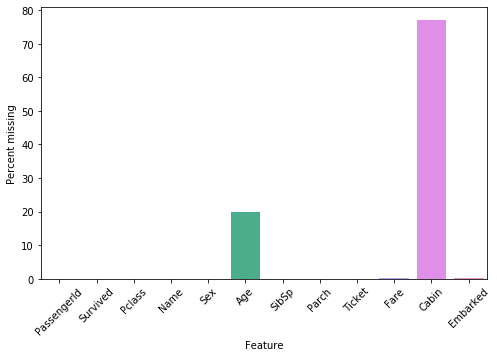

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize = (8,5))
plt.xticks(rotation = 45)
sns.barplot(x= "Feature", y="Percent missing",data = null_values)

In [6]:
#Cabin has ~80 percent of missing values, so let's drop the column.

df_train_valid_2 = df_train_valid.drop("Cabin",axis = 1)
df_train_valid_2.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,S


In [7]:
#Converting the type of column from object to category

from pandas.api.types import is_string_dtype

def string_to_category(df):
    for p,q in df.items():
        if is_string_dtype(q):
            df[p] = q.astype('category').cat.as_ordered()
    return df

In [8]:
df_train_valid_3 = string_to_category(df_train_valid_2)
df_train_valid_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1100 non-null   int64   
 1   Survived     1100 non-null   int64   
 2   Pclass       1100 non-null   int64   
 3   Name         1100 non-null   category
 4   Sex          1100 non-null   category
 5   Age          881 non-null    float64 
 6   SibSp        1100 non-null   int64   
 7   Parch        1100 non-null   int64   
 8   Ticket       1100 non-null   category
 9   Fare         1099 non-null   float64 
 10  Embarked     1098 non-null   category
dtypes: category(4), float64(2), int64(5)
memory usage: 161.8 KB


In [9]:
print(df_train_valid_3.Embarked.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')


In [10]:
#Impute missing values
#Categorical NaN's to 0
#Missing continuous variables with median values of that column

from pandas.api.types import is_numeric_dtype
import sys

def df_to_nums(df,feature,null_status):
    if not is_numeric_dtype(feature):
        df[null_status] = feature.cat.codes+1

def df_impute(df,feature,null_status,null_table):
    #print(feature)
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table

def df_preprocessor(df,null_table):
    if null_table is None:
        null_table = dict()
    for p,q in df.items():
        #sys.stdout.write(p)
        null_table = df_impute(df,q,p,null_table)
    #sys.stdout.flush()
    for p,q in df.items():
        df_to_nums(df,q,p);
    df = pd.get_dummies(df,dummy_na = True)
    res = [df,null_table]
    return res

In [11]:
df_train_valid_4,my_table = df_preprocessor(df_train_valid_3,null_table = None)
df_train_valid_4.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
0,1,0,3,135,2,22.0,1,0,629,7.2500,3,False,False
1,2,1,1,245,1,38.0,1,0,713,71.2833,1,False,False


In [12]:
#Values by which the missing continuous variables are replaced

my_table

{'Age': 28.0, 'Fare': 14.4583}

In [13]:
#vertical split of the dataframe, The Y column is the variable that we are trying to predict.

Y = df_train_valid_4["Survived"]
X = df_train_valid_4.drop(["Survived"],axis = 1)
print(X.shape,Y.shape)

(1100, 12) (1100,)


In [14]:
#Split continuous column variables and categorical column variables

X_categorical = X[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_continuous = X.drop(X_categorical,axis = 1)
print(X_categorical.shape,X_continuous.shape)

(1100, 10) (1100, 2)


In [15]:
#Scale all continuous variables between 0-1 (standardization and normalization)

from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_continuous)
X_con_scaled = pd.DataFrame(scaler.transform(X_continuous))
X_con_scaled.columns = ["Age","Fare"]
print(X_con_scaled.shape)
X_con_scaled.head(2)

(1100, 2)


,Age,Fare
0,-0.574896,-0.502155
1,0.659705,0.747957


In [16]:
#Join categorical and scaled continuous variables

df_list = [X_categorical,X_con_scaled];
X_full = pd.concat(df_list,axis = 1)
print(X_full.shape)
X_full.head(2)

(1100, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1,3,135,2,1,0,629,3,False,False,-0.574896,-0.502155
1,2,1,245,1,1,0,713,1,False,False,0.659705,0.747957


In [17]:
#Split dataframe into train and valid sets for model building and hyperparameter tuning

X_train,X_valid = split_df(X_full,900)
Y_train,Y_valid = split_df(Y,900)
print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)

(900, 12) (200, 12) (900,) (200,)


In [18]:
#Training the model 

from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors = 5,weights = 'uniform')
knn_model.fit(X_train,Y_train)
Y_pred = knn_model.predict(X_valid)

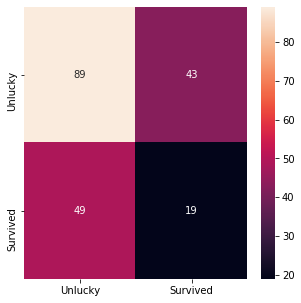

In [19]:
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score

knn_cmatrix = confusion_matrix(Y_valid,Y_pred)
knn_df = pd.DataFrame(knn_cmatrix)
plt.figure(figsize = (5,5))
sns.heatmap(knn_df,xticklabels = ["Unlucky","Survived"],
            yticklabels = ["Unlucky","Survived"],annot = True)

In [20]:
print(accuracy_score(Y_valid,Y_pred,normalize = True),
     matthews_corrcoef(Y_valid,Y_pred),
      f1_score(Y_valid,Y_pred))

0.54 -0.0474697036788388 0.29230769230769227


## Hyperparameter Tuning

In [21]:
# The value of n_neighbors(k) ranges from 1 to 20
# Algorithms used to compute the nearest neighbors are'auto' and 'ball_tree'
# Weight function used in prediction are 
#  1. ‘uniform’ : All points in each neighborhood are weighted equally. 
#  2.‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point 
#                 will have a greater influence than neighbors which are further away
# Metrics tested are 'minkowski'and 'euclidean'

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import numpy as np

knn_model = KNeighborsClassifier()
n_range = np.arange(20)+1
algorithm=['auto','ball_tree']
weights=['uniform','distance']
metric=['minkowski','euclidean']
param_grid={'algorithm':algorithm,'weights':weights,'n_neighbors':n_range,'metric':metric}

knn_cv = GridSearchCV(knn_model,param_grid)
knn_cv.fit(X_train,Y_train)
Y_pred = knn_cv.predict(X_valid)
results = pd.DataFrame(knn_cv.cv_results_)

In [22]:
pd.set_option('max_colwidth', 100)
pd.set_option('max_row', 160)
params_df =  pd.DataFrame(knn_cv.cv_results_['params'])
test_score_df =  pd.DataFrame(knn_cv.cv_results_['mean_test_score'])

In [23]:
df_concat_list = [params_df,test_score_df]
results_df = pd.concat(df_concat_list,axis = 1)

In [24]:
results_df.columns=['Algorithm','Distance_Metric','Number_of_Neighbors','Weights','Test_score']
results_df

,Algorithm,Distance_Metric,Number_of_Neighbors,Weights,Test_score
0,auto,minkowski,1,uniform,0.575556
1,auto,minkowski,1,distance,0.575556
2,auto,minkowski,2,uniform,0.571111
3,auto,minkowski,2,distance,0.575556
4,auto,minkowski,3,uniform,0.555556
5,auto,minkowski,3,distance,0.555556
6,auto,minkowski,4,uniform,0.573333
7,auto,minkowski,4,distance,0.565556
8,auto,minkowski,5,uniform,0.551111
9,auto,minkowski,5,distance,0.551111


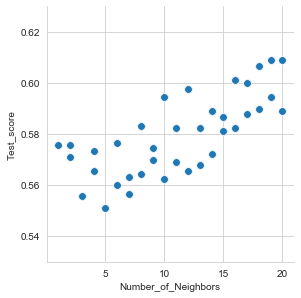

In [25]:
#Plot Number of neighbors vs Test score

results_df.to_csv("results.csv",index = False)
sns.set_style("whitegrid")
sns.pairplot(results_df,x_vars = "Number_of_Neighbors",
             y_vars = "Test_score",plot_kws = {'s': 60},height = 4.0)

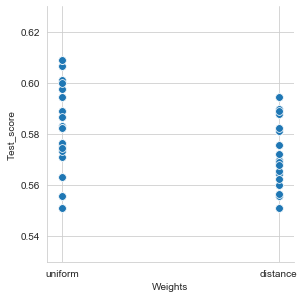

In [26]:
#Plot Weights vs Test score

sns.pairplot(results_df,x_vars = "Weights",
             y_vars = "Test_score",plot_kws = {'s': 60},height = 4.0)

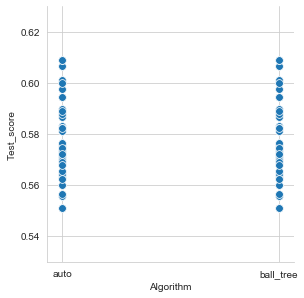

In [27]:
#Plot Algorithm vs Test score

sns.pairplot(results_df,x_vars = "Algorithm",
             y_vars = "Test_score",plot_kws = {'s': 60},height = 4.0)

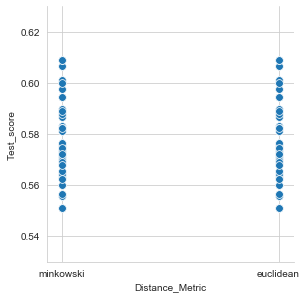

In [28]:
#Plot Distance metric vs Test score

sns.pairplot(results_df,x_vars = "Distance_Metric",
             y_vars = "Test_score",plot_kws = {'s': 60},height = 4.0)

In [29]:
#Save with joblib

from sklearn.externals import joblib

knn_model_fin = KNeighborsClassifier(n_neighbors = 20,weights = 'uniform')
knn_model_fin.fit(X_full,Y)

!mkdir knn_model_2
knn_model_name = f'{my_path}/knn_model_2/knn_model_final.sav'
joblib.dump(knn_model_fin,knn_model_name)

mkdir: knn_model_2: File exists


/Users/Mrs.Ashrith/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['/Users/Mrs.Ashrith/Desktop/DataScience/Module3/knn_model_2/knn_model_final.sav']

In [30]:
!ls knn_model

knn_model_final.sav


In [31]:
knn_model_loaded = joblib.load(knn_model_name)

## Evaluating Test set Accuracy

In [32]:
df_test.shape
df_test.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,NaN,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,NaN,S


In [33]:
#Pre-process the test set in exactly the same way as train_valid set
#Cabin has ~80 percent of missing values, so let's drop the column.

df_test1 = df_test.drop("Cabin",axis = 1)
print(df_test1.shape)
df_test1.head(3)

(209, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,S
1102,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,S


In [34]:
#Converting the type of column from object to category.

df_test2 = string_to_category(df_test1)
df_test2.Sex.cat.categories

Index(['female', 'male'], dtype='object')

In [35]:
df_test2.Embarked.cat.categories

Index(['C', 'Q', 'S'], dtype='object')

In [36]:
#Impute missing values

df_test3,my_table1 = df_preprocessor(df_test2,null_table = my_table)
print(df_test3.shape)
df_test3.head(3)

(209, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
1100,1101,1,3,47,2,25.0,0,0,106,7.8958,3,False,False
1101,1102,0,3,6,2,32.0,0,0,146,22.5250,3,False,False
1102,1103,1,3,62,2,28.0,0,0,187,7.0500,3,True,False


In [37]:
#Vertical split of the dataframe, The Y column is the variable that we are trying to predict.

Y_t = df_test3["Survived"]
X_t = df_test3.drop(["Survived"],axis = 1)
print(X_t.shape,Y_t.shape)

(209, 12) (209,)


In [38]:
#Split continuous column variables and categorical column variables

X_cat_t = X_t[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch','Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con_t = X_t.drop(X_cat_t,axis = 1)
print(X_cat_t.shape,X_con_t.shape)

(209, 10) (209, 2)


In [39]:
#Scale all continuous variables between 0-1 (standardization and normalization)

X_con_sct = pd.DataFrame(scaler.transform(X_con_t))
X_con_sct.columns = ["Age","Fare"]
print(X_con_sct.shape,X_cat_t.shape,X_con_sct.shape)
X_con_sct.head(2)

(209, 2) (209, 10) (209, 2)


,Age,Fare
0,-0.343408,-0.489547
1,0.196729,-0.203944


In [40]:
#Re-index before merging
X_cat_t.reset_index(inplace = True,drop = False)

In [41]:
X_cat_t.head()

,index,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1100,1101,3,47,2,0,0,106,3,False,False
1,1101,1102,3,6,2,0,0,146,3,False,False
2,1102,1103,3,62,2,0,0,187,3,True,False
3,1103,1104,2,45,2,0,0,179,3,False,False
4,1104,1105,2,91,1,1,0,38,3,False,False


In [42]:
X_cat_t.drop("index",inplace = True,axis = 1)
X_cat_t.head(2)

/Users/Mrs.Ashrith/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1101,3,47,2,0,0,106,3,False,False
1,1102,3,6,2,0,0,146,3,False,False


In [43]:
#Join categorical and scaled continuous variables

df_list_1 = [X_cat_t,X_con_sct]
X_test_1 = pd.concat(df_list_1,axis = 1)
print(X_test_1.shape)
X_test_1.head(2)

(209, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1101,3,47,2,0,0,106,3,False,False,-0.343408,-0.489547
1,1102,3,6,2,0,0,146,3,False,False,0.196729,-0.203944


In [44]:
kNN_loaded = joblib.load(f'{my_path}/knn_model_2/knn_model_final.sav')

In [45]:
#Testing

Y_test_pred = kNN_loaded.predict(X_test_1)

In [46]:
#Accuracy

print(accuracy_score(Y_t,Y_test_pred),
      matthews_corrcoef(Y_t,Y_test_pred),f1_score(Y_t,Y_test_pred))

0.5645933014354066 0.0 0.0


/Users/Mrs.Ashrith/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [47]:
X_full["Survived"] = Y
X_test_1["Survived"] = Y_t
print(X_full.shape)
print(X_test_1.shape)

(1100, 13)
(209, 13)
